In [16]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import re
import string
import random

import nltk
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Dropout, BatchNormalization, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from textblob import TextBlob
from gensim.models.fasttext import FastText
from spacy.lang.en.stop_words import STOP_WORDS
from plotly import graph_objs as go
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
from nltk import pos_tag

In [29]:
from nbformat import read

def count_words_in_notebook(notebook_path):
    total_words = 0
    
    with open(notebook_path, 'r', encoding='utf-8') as f:
        notebook = read(f, as_version=4)
        
        # Iterate over notebook cells
        for cell in notebook.cells:
            # Consider only markdown cells
            if cell.cell_type == 'markdown':
                # Tokenize the markdown cell content and count the words
                markdown_words = cell.source.split()
                total_words += len(markdown_words)
                
    return total_words

# Calculate the total number of words [Markdown cells]
notebook_path = 'MSIN0097_Individual Coursework_23047040.ipynb'
total_words = count_words_in_notebook(notebook_path)
print("Total words in Markdown cells of the notebook and reference:", total_words)


Total words in Markdown cells of the notebook and reference: 2038


In [30]:
Reference_word = 127
Final_words = total_words - 127 
print("Total words in Markdown cells of the notebook:", Final_words)

Total words in Markdown cells of the notebook: 1911


# Introduction and Data Cleaning

In a world where tweets flow incessantly, the impact of sentiment on a brand or individual's reputation is profound. Sentiment Analysis is a method for judging somebody's sentiment or feeling with respect to a specific thing (Tyagi & Sharma, 2018). The ability to discern whether a tweet carries a positive, negative, or neutral sentiment can dictate the trajectory of reactions and decisions, often within seconds. The dataset provided is a twitter comments that has been meticulously curated from Figure Eight's Data for, offering labeled sentiment annotations.


In a world where tweets flow incessantly, the impact of sentiment on a brand or individual's reputation is profound. Sentiment Analysis, as described by Tyagi and Sharma (2018), serves as a method for discerning sentiment or feelings towards a specific entity or topic. With tweets capable of swiftly shaping perceptions and influencing decisions, the ability to classify sentiment as positive, negative, or neutral holds immense importance. The dataset provided, extracted from Kaggle's Tweet Sentiment Extraction competition, has been meticulously curated from Figure Eight's Data for, offering labeled sentiment annotations. 

The report begins with exploratory data analysis to uncover patterns and insights through various visualizations. Subsequently, three models are employed: logistic regression as the traditional approach, followed by models leveraging fasttext embedding and LSTM architecture. The primary objective is to evaluate the performance of these models, particularly highlighting the effectiveness of CNN and the impact of fine-tuning on sentiment classification accuracy.

In [7]:
df = pd.read_csv('TwitterSentiment.csv')

In [8]:
df

textID                                               text sentiment
0      cb774db0d1                I`d have responded, if I were going   neutral
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!  negative
2      088c60f138                          my boss is bullying me...  negative
3      9642c003ef                     what interview! leave me alone  negative
4      358bd9e861   Sons of ****, why couldn`t they put them on t...  negative
...           ...                                                ...       ...
31010  e5f0e6ef4b  its at 3 am, im very tired but i can`t sleep  ...  negative
31011  416863ce47  All alone in this old house again.  Thanks for...  positive
31012  6332da480c   I know what you mean. My little dog is sinkin...  negative
31013  df1baec676  _sutra what is your next youtube video gonna b...  positive
31014  469e15c5a8   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive

[31015 rows x 3 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31015 entries, 0 to 31014
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     31015 non-null  object
 1   text       31014 non-null  object
 2   sentiment  31015 non-null  object
dtypes: object(3)
memory usage: 727.0+ KB


In [10]:
# Drop a null value
df = df.dropna()
df.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [11]:
data = df.copy()

# Exploratory Data Analysis


The analysis of the dataset primarily involved generating visualizations to delve into key trends. Given the dataset's limitation to a single column, "text", additional insights were extracted by creating supplementary columns derived from text analysis. These analyses were complemented by a diverse set of visualizations, including pie charts, word clouds, bar plots, histograms, scatter plots, funnel charts, and donut charts. These visualizations collectively provided a comprehensive understanding of the dataset and allowed for the exploration of various trends and patterns within the text data.

In [82]:
df.head(5)

textID                                               text sentiment
0  cb774db0d1                I`d have responded, if I were going   neutral
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!  negative
2  088c60f138                          my boss is bullying me...  negative
3  9642c003ef                     what interview! leave me alone  negative
4  358bd9e861   Sons of ****, why couldn`t they put them on t...  negative

In [83]:
# Count the total text of each sentiment
print('Total for each sentiment')
df['sentiment'].value_counts()

Total for each sentiment


sentiment
neutral     12547
positive     9685
negative     8782
Name: count, dtype: int64

In [84]:
# Check if there is any duplicates of user ID
duplicates = df.duplicated(subset=['textID'])

if duplicates.any():
    print("Duplicates found in 'textID' column:")
    print(df[duplicates])
else:
    print("No duplicates found in 'textID' column.")

No duplicates found in 'textID' column.


<Axes: xlabel='sentiment', ylabel='count'>

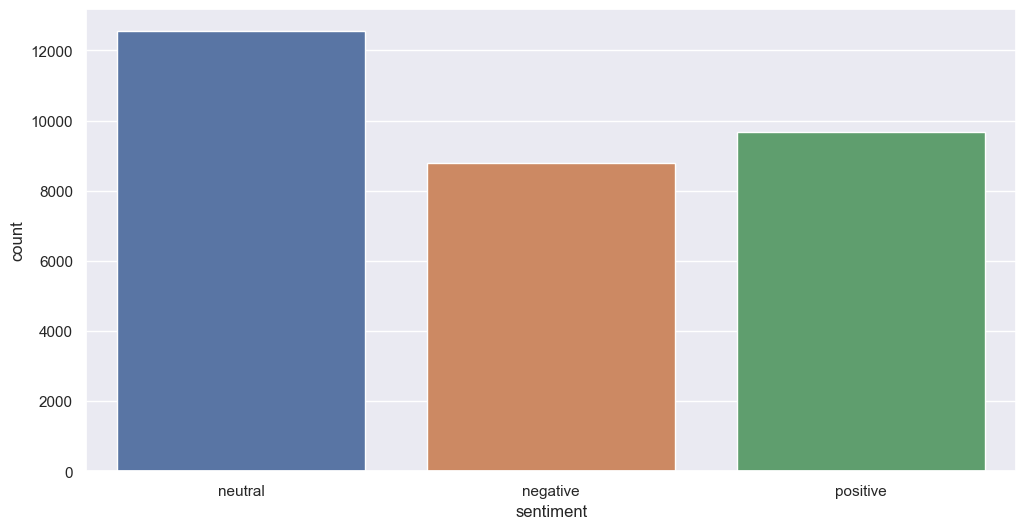

In [85]:
# Bar Chart to make it more accessible to interpret
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df)

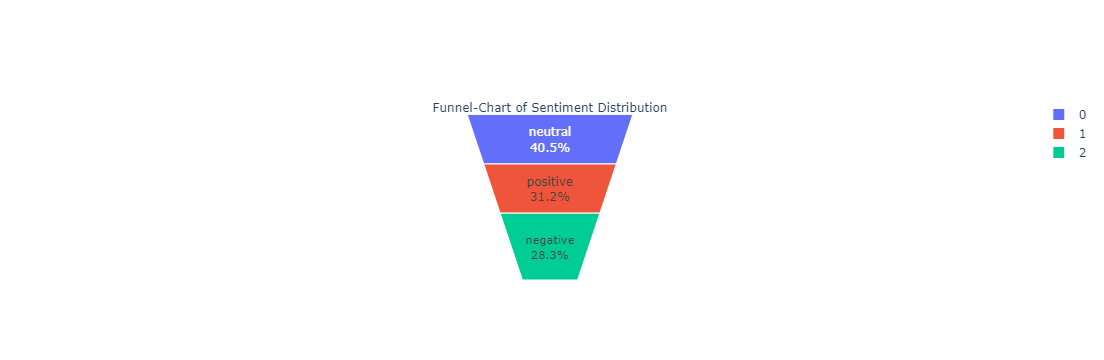

In [86]:
# Visualizing sentiment distribution using a funnel chart to understand the proportion of each sentiment category in the dataset
funnel = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)

fig = go.Figure(go.Funnelarea(
    text =funnel.sentiment,
    values = funnel.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

It seems the data is distributed with a higher number of neutral samples compared to positive and negative samples. This indicates that the dataset may be more balanced towards neutral sentiments. However, further analysis is needed to understand the distribution of words within each sentiment category.

To augment the analysis with additional visualizations, I generate meta-features by creating new columns in the DataFrame. These columns will contain derived statistics or attributes related to the text data, enabling a deeper exploration and interpretation of the dataset.

C:\Users\ynels\AppData\Local\Temp\ipykernel_17200\3964647112.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



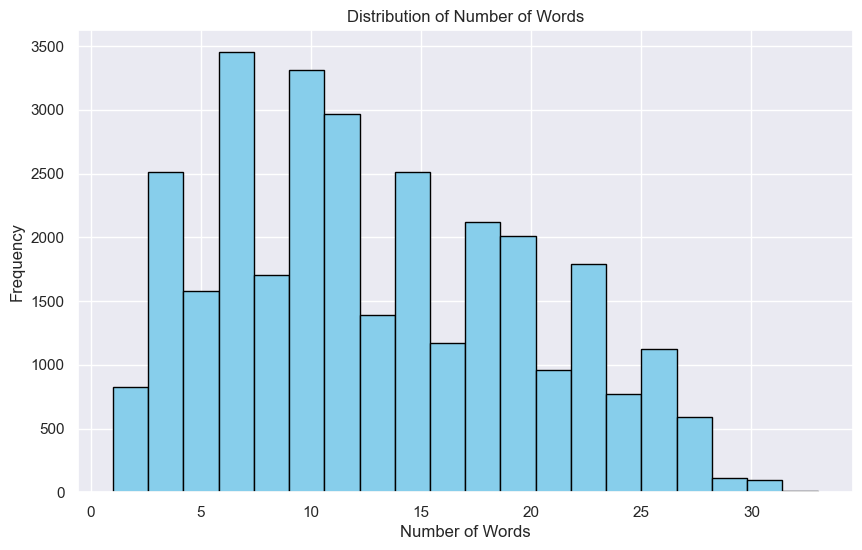

In [87]:
# Calculate number of words in each text sample
df.loc[:, 'num_words'] = df['text'].apply(lambda x: len(x.split()))

# Visualize the distribution of number of words
plt.figure(figsize=(10, 6))
plt.hist(df['num_words'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words')
plt.grid(True)
plt.show()


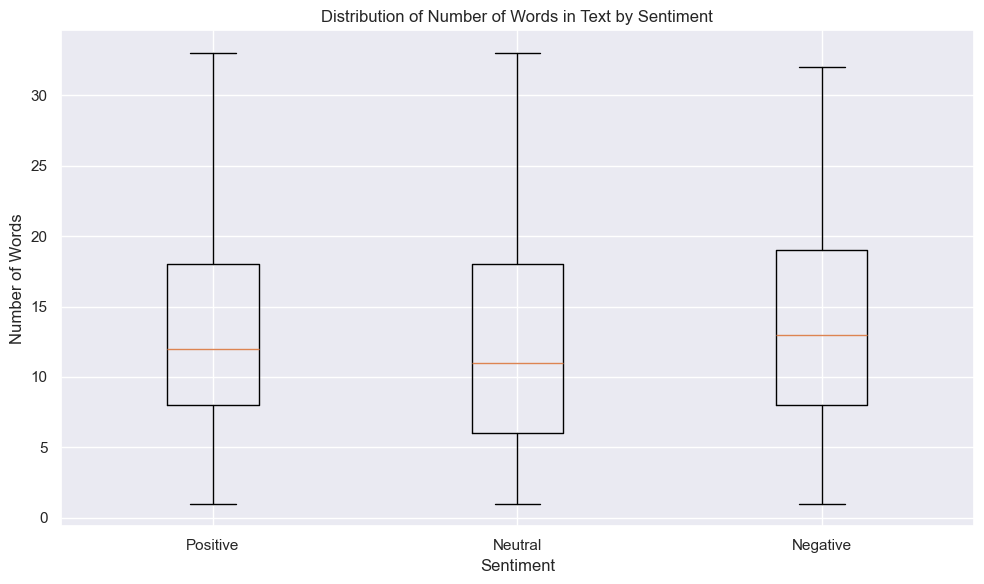

In [88]:
# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot([df[df['sentiment'] == 'positive']['num_words'],
             df[df['sentiment'] == 'neutral']['num_words'],
             df[df['sentiment'] == 'negative']['num_words']],
            labels=['Positive', 'Neutral', 'Negative'])

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.title('Distribution of Number of Words in Text by Sentiment')

plt.grid(True)
plt.tight_layout()
plt.show()

The median number of words for each sentiment appears to be relatively close. The range appears to be slightly wider for neutral texts, suggesting greater variability in the length of neutral texts compared to positive and negative ones.

In [89]:
# Separate DataFrames for each sentiment
positive_df = df[df['sentiment'] == 'positive']
negative_df = df[df['sentiment'] == 'negative']
neutral_df = df[df['sentiment'] == 'neutral']

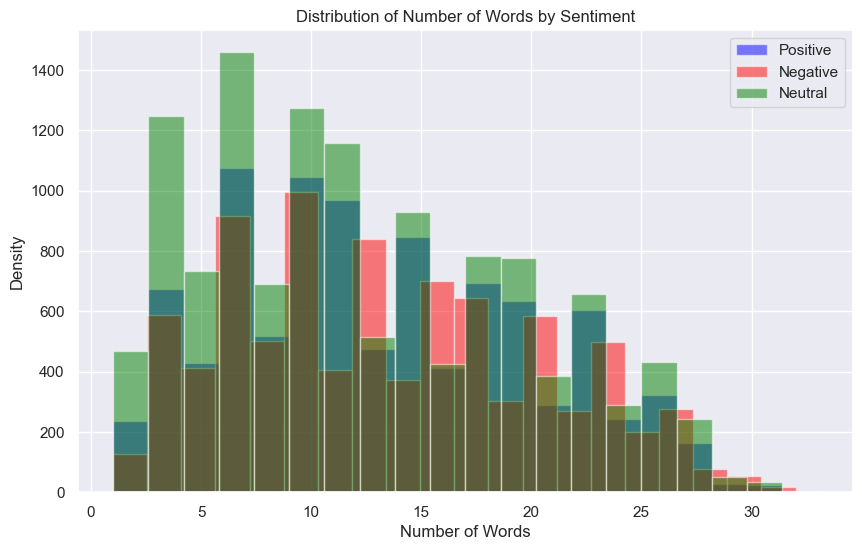

In [90]:
# Visualization of total number of each word for positive, negative and neutral sentiments
plt.figure(figsize=(10, 6))

# Plot histograms for each sentiment category
plt.hist(positive_df['num_words'], bins=20, color='blue', alpha=0.5, label='Positive')
plt.hist(negative_df['num_words'], bins=20, color='red', alpha=0.5, label='Negative')
plt.hist(neutral_df['num_words'], bins=20, color='green', alpha=0.5, label='Neutral')

# Add labels and title
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.title('Distribution of Number of Words by Sentiment')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


I employed Plotly to craft interactive visualizations, facilitating further analysis of the sentiment distribution and other patterns within the dataset.

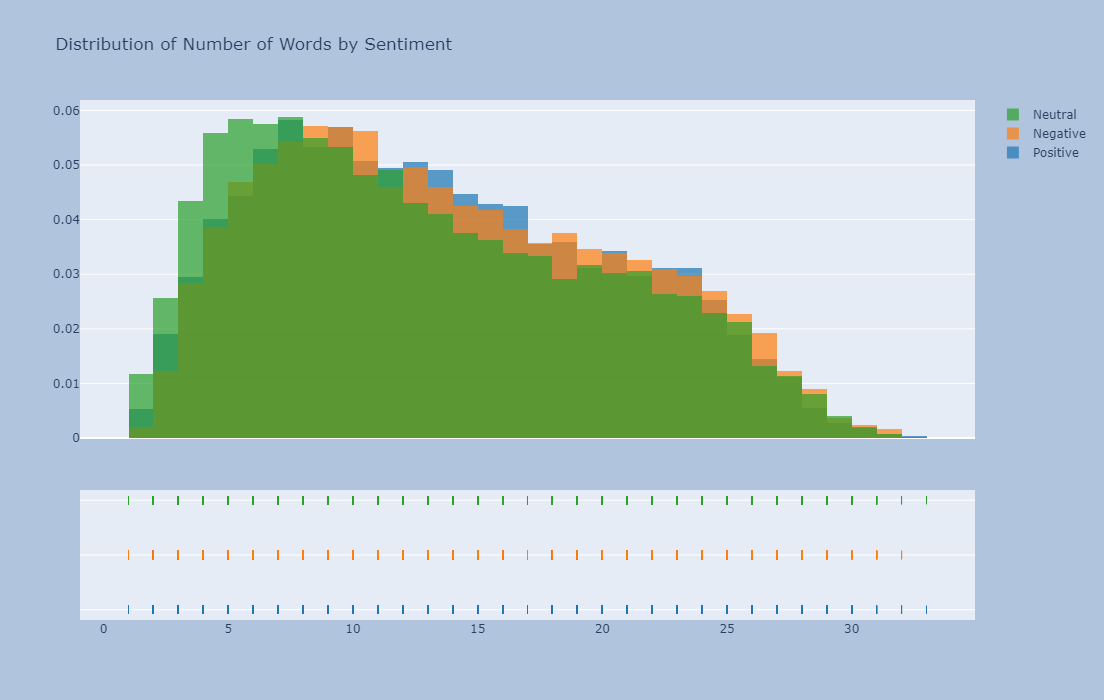

In [91]:
# Define the histogram data for each sentiment category
hist_data = [positive_df['num_words'], negative_df['num_words'], neutral_df['num_words']]

# Define group labels
group_labels = ['Positive', 'Negative', 'Neutral']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, show_curve=False)

# Update layout and display the plot
fig.update_layout(title_text='Distribution of Number of Words by Sentiment',
                  autosize=False,
                  width=900,
                  height=700,
                  paper_bgcolor="LightSteelBlue")

fig.show()


The graph displays a histogram of word counts categorized by sentiment: positive (blue), negative (red), and neutral (green). Most entries contain 0-17 words, with neutral words being the most frequent from 0-5, negative from 8-11 and positive from 12-17. The frequency of words declines as the word count increases for all sentiments.

I plan to create a word cloud visualization to further explore the textual data and identify prominent words within each sentiment category. I also created a donut plot to see top 20 words used for each sentiments.

In [92]:
# Preprocess text data by tokenizing, removing stopwords and punctuation, performing part-of-speech tagging, and lemmatizing verbs and adjectives.
def get_wordnet_pos(tag):
    """Map POS tag to first character lemmatize() accepts"""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    else:
        return None

def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and punctuation marks, and lowercase
    stop_words = set(stopwords.words('english'))
    tokens = [word.lower() for word in tokens if word.lower() not in stop_words and word not in string.punctuation]
    # Part-of-speech tagging
    tagged_tokens = pos_tag(tokens)
    # Lemmatize verbs and adjectives
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_tokens if get_wordnet_pos(tag)]
    return tokens


In [93]:
# Preprocess text for each sentiment
positive_words = [word for text in positive_df['text'] for word in preprocess_text(text)]
negative_words = [word for text in negative_df['text'] for word in preprocess_text(text)]
neutral_words = [word for text in neutral_df['text'] for word in preprocess_text(text)]

In [94]:
# Count word frequencies
positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)
neutral_word_freq = Counter(neutral_words)

In [95]:
type(positive_word_freq)

collections.Counter

In [96]:
# Load a mask image
mask_image = np.array(Image.open("mask_image.png"))

# Because the image is considered a square, we need to adjust it to the shape of the image
# Convert the image to a NumPy array to check its shape
mask_array = np.array(mask_image)

# We'll check the shape of the image and also display it to understand its contents.
mask_shape = mask_array.shape
mask_shape

(512, 512, 4)

In [97]:
# Convert the mask image to a NumPy array
mask_array = np.array(mask_image)

# Ensure the mask array has RGBA channels and add alpha channel with full opacity to preserve transparency
if mask_array.shape[2] == 3:
    mask_array = np.dstack((mask_array, np.full((mask_array.shape[0], mask_array.shape[1]), 255, dtype=np.uint8)))

# Get the dimensions of the image
height, width, _ = mask_array.shape

# Iterate over each pixel in the image
for y in range(height):
    for x in range(width):
        # Check if the pixel belongs to the Twitter bird
        if np.all(mask_array[y, x, :3] < 200):
            mask_array[y, x, :3] = [255, 255, 255]

# Save the modified mask image
modified_mask_image = Image.fromarray(mask_array)
modified_mask_image.save("twitter_logo_modified.png")

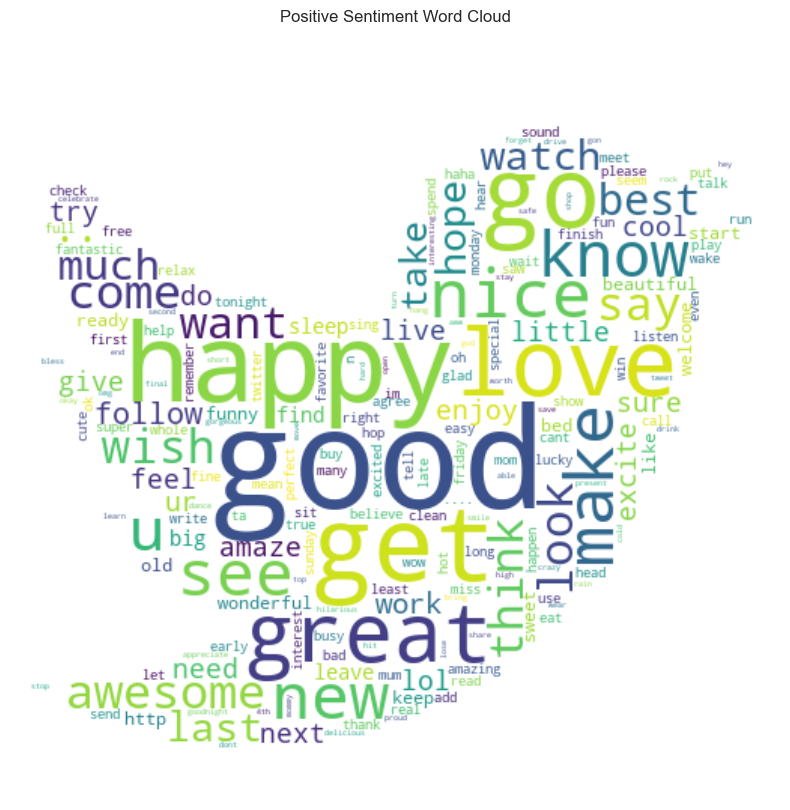

In [98]:
mask_image = np.array(Image.open("twitter_logo_modified.png"))

# Generate word cloud with mask
wordcloud = WordCloud(width=2000, height=2000, background_color='white', mask=mask_image).generate_from_frequencies(positive_word_freq)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')
plt.show()

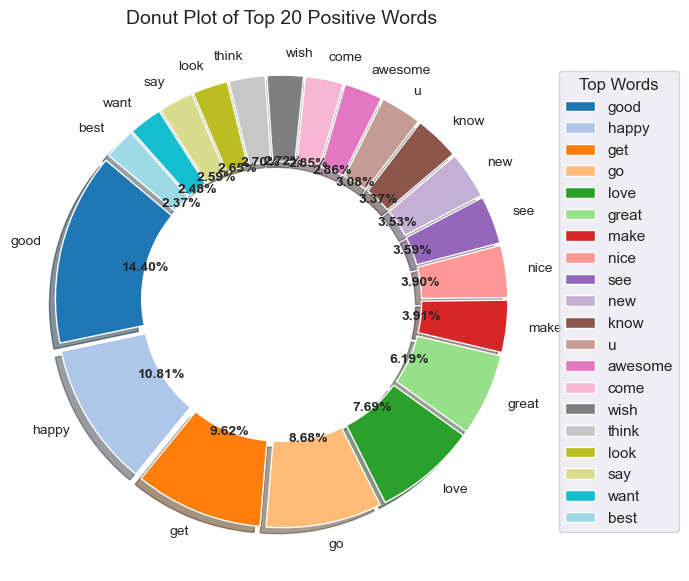

In [99]:
# Sort the positive_word_freq Counter by frequency in descending order
sorted_positive_word_freq = dict(sorted(positive_word_freq.items(), key=lambda item: item[1], reverse=True))

# Extract the top 20 words and their frequencies
top_words = list(sorted_positive_word_freq.keys())[:20]
top_counts = list(sorted_positive_word_freq.values())[:20]

# Donut plot
colors = plt.cm.tab20.colors 
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(top_counts, labels=top_words, autopct='%1.2f%%',
                                  wedgeprops=dict(width=0.4), colors=colors,
                                  startangle=140, explode=[0.05]*20, shadow=True
                                 )


plt.setp(texts, size=10, weight="normal")
plt.setp(autotexts, size=10, weight="bold")


ax.legend(wedges, top_words,
          title="Top Words",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Donut Plot of Top 20 Positive Words', fontsize=14)
plt.show()


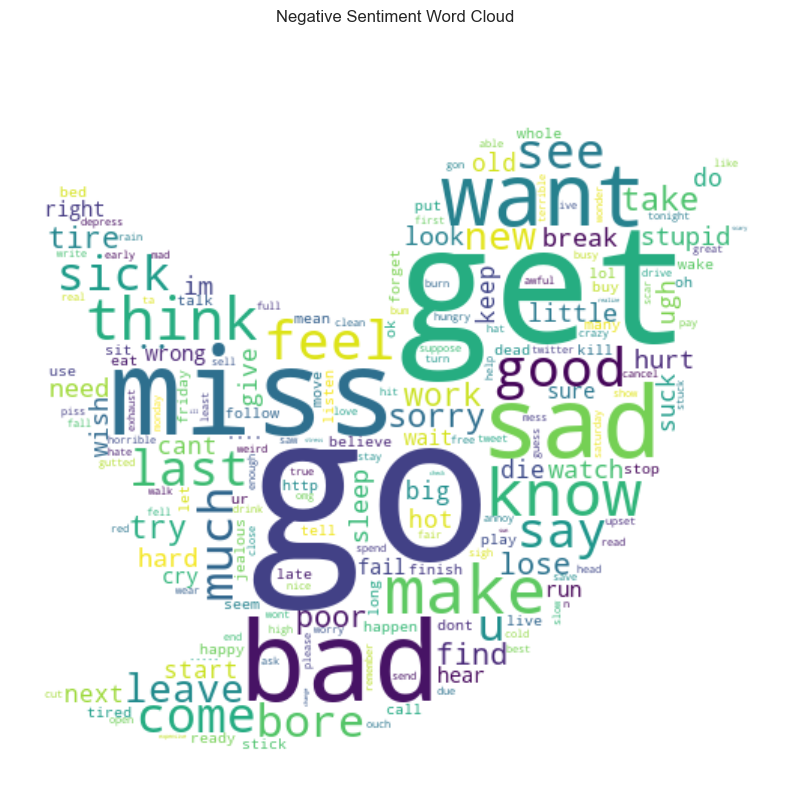

In [100]:
# Generate word cloud with mask
wordcloud = WordCloud(width=2000, height=2000, background_color='white', mask=mask_image).generate_from_frequencies(negative_word_freq)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()

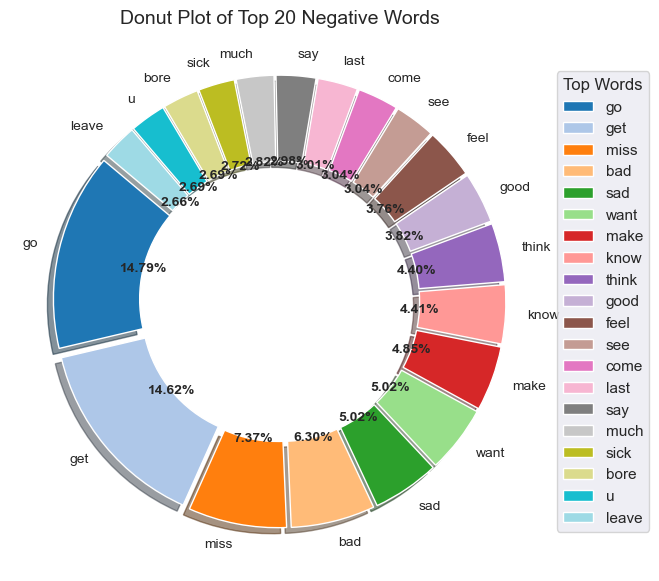

In [101]:
# Sort the positive_word_freq Counter by frequency in descending order
sorted_negative_word_freq = dict(sorted(negative_word_freq.items(), key=lambda item: item[1], reverse=True))

# Extract the top 20 words and their frequencies
top_words = list(sorted_negative_word_freq.keys())[:20]
top_counts = list(sorted_negative_word_freq.values())[:20]

# Donut plot
colors = plt.cm.tab20.colors 
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(top_counts, labels=top_words, autopct='%1.2f%%',
                                  wedgeprops=dict(width=0.4), colors=colors,
                                  startangle=140, explode=[0.05]*20, shadow=True
                                 )


plt.setp(texts, size=10, weight="normal")
plt.setp(autotexts, size=10, weight="bold")


ax.legend(wedges, top_words,
          title="Top Words",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Donut Plot of Top 20 Negative Words', fontsize=14)
plt.show()


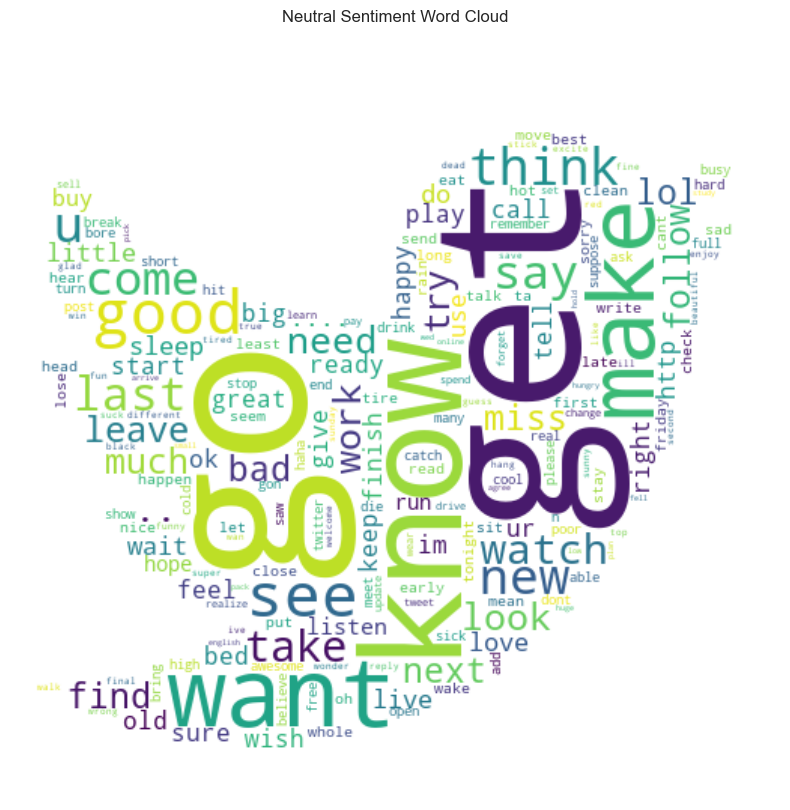

In [102]:
# Generate word cloud with mask
wordcloud = WordCloud(width=2000, height=2000, background_color='white', mask=mask_image).generate_from_frequencies(neutral_word_freq)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment Word Cloud')
plt.axis('off')
plt.show()

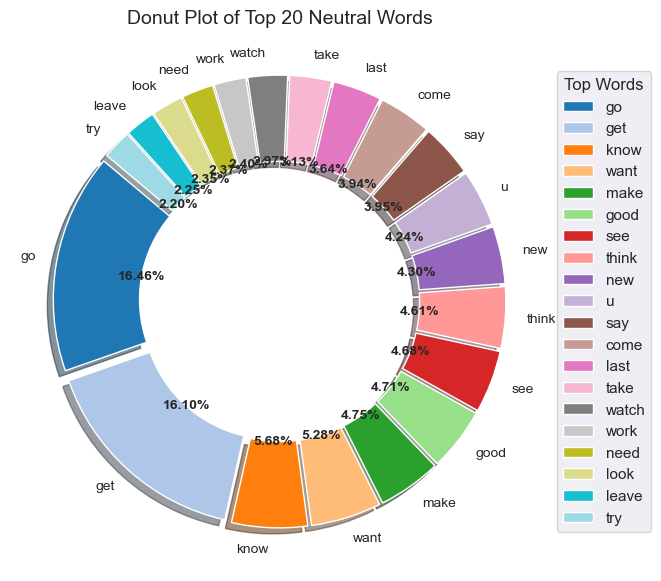

In [103]:
# Sort the positive_word_freq Counter by frequency in descending order
sorted_neutral_word_freq = dict(sorted(neutral_word_freq.items(), key=lambda item: item[1], reverse=True))

# Extract the top 20 words and their frequencies
top_words = list(sorted_neutral_word_freq.keys())[:20]
top_counts = list(sorted_neutral_word_freq.values())[:20]

# Donut plot
colors = plt.cm.tab20.colors 
fig, ax = plt.subplots(figsize=(10, 7), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(top_counts, labels=top_words, autopct='%1.2f%%',
                                  wedgeprops=dict(width=0.4), colors=colors,
                                  startangle=140, explode=[0.05]*20, shadow=True
                                 )


plt.setp(texts, size=10, weight="normal")
plt.setp(autotexts, size=10, weight="bold")


ax.legend(wedges, top_words,
          title="Top Words",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Donut Plot of Top 20 Neutral Words', fontsize=14)
plt.show()


Large, prominent words like "happy," "love," "nice," and "enjoy" suggest that these are some of the most commonly expressed positive sentiments. While words such as "bad," "miss," "sad," and "wrong" stand out, indicating that they are common in negative tweets. On the other hand, words like "think," "know," "say," and "come" are more about conveying information or discussing topics without strong emotional content. These words are typically used in everyday conversation and can be seen as indicative of more factual or objective tweets.

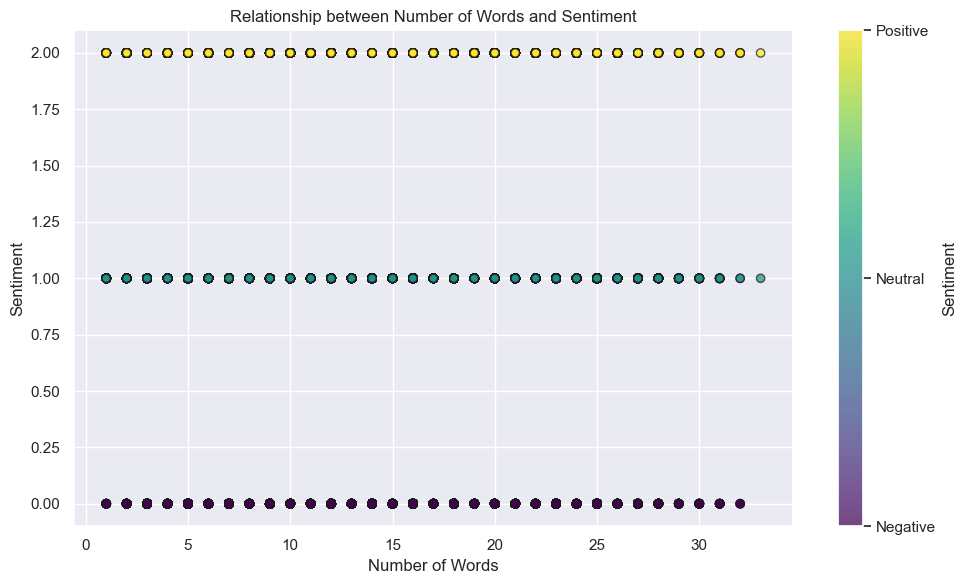

In [105]:
# Scatter plot to see if there is any correlation of number of words and the sentiment
# Assign numerical values to sentiment categories
sentiment_values = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_value'] = df['sentiment'].map(sentiment_values)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['num_words'], df['sentiment_value'], c=df['sentiment_value'], cmap='viridis', alpha=0.7, edgecolors='k')
plt.xlabel('Number of Words')
plt.ylabel('Sentiment')
plt.title('Relationship between Number of Words and Sentiment')

cbar = plt.colorbar(scatter, ticks=[0, 1, 2])
cbar.set_label('Sentiment')
cbar.set_ticklabels(['Negative', 'Neutral', 'Positive'])

plt.grid(True)
plt.tight_layout()
plt.show()

This plot indicates that within this dataset, sentiment scores are consistent across texts regardless of their length, meaning there is no clear relationship between the number of words in the text (as per the x-axis) and the sentiment score (as per the y-axis)

In [106]:
# Function to count punctuation marks in text
def count_punctuation(text):
    punctuation_count = {}
    tokens = word_tokenize(text)
    for token in tokens:
        if token in ['!', '.', '?', ',', ';', ':','*','$','#']:
            if token in punctuation_count:
                punctuation_count[token] += 1
            else:
                punctuation_count[token] = 1
    return punctuation_count

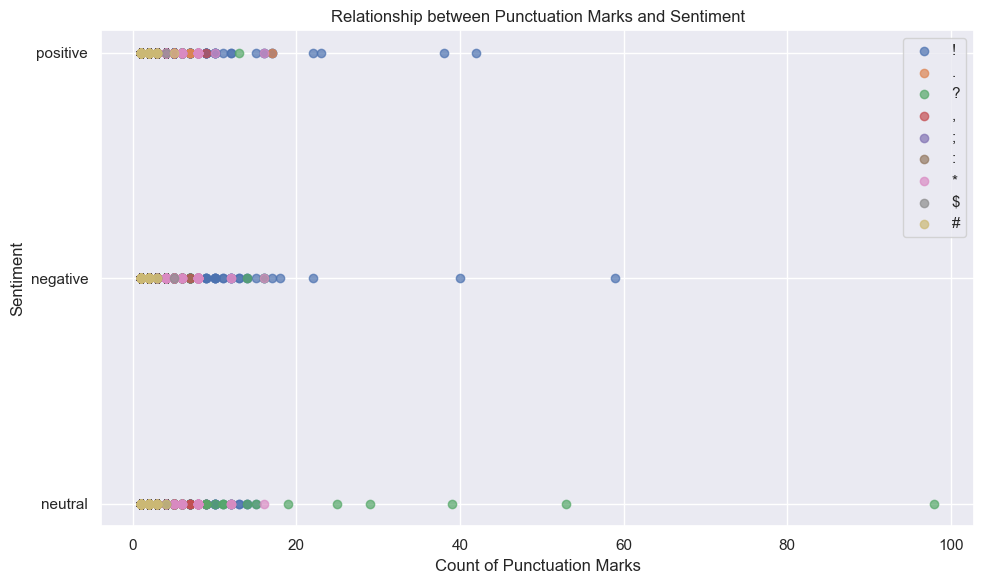

In [107]:
# Apply count_punctuation function to each row and extract punctuation counts into separate columns
df['punctuation_counts'] = df['text'].apply(count_punctuation)
df = pd.concat([df.drop(['punctuation_counts'], axis=1), df['punctuation_counts'].apply(pd.Series, dtype=float)], axis=1)

plt.figure(figsize=(10, 6))
punctuation_marks = ['!', '.', '?', ',', ';', ':', '*','$','#']
for mark in punctuation_marks:
    plt.scatter(df[mark], df['sentiment'], label=mark, alpha=0.7)
    
plt.xlabel('Count of Punctuation Marks')
plt.ylabel('Sentiment')
plt.title('Relationship between Punctuation Marks and Sentiment')


plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Based on the colors depicted in the scatter plot, it appears that the neutral sentiment category exhibits a relatively higher frequency of question marks (?), whereas both positive and negative categories demonstrate more frequent usage of exclamation marks (!). This observation may imply that neutral texts tend to convey curiosity or uncertainty, as denoted by question marks, while positive and negative texts are more expressive or emphatic, typically indicated by exclamation marks. However, due to the limited size of the text data, it might be preferable to remove these punctuation marks before conducting sentiment analysis.

# Sentiment Analysis 

## Model 1 : Logistic Regression

Logistic regression is a classification algorithm used to classify linear logarithms (Hidayat, T. H. J., et al., 2022). The process involves preprocessing, followed by the application of functions such as is_good, is_bad, and is_neutral, and then applying the model. This manual method serves as a benchmark to evaluate the performance of other models.

In [11]:
# Data Preparation
df = data.copy()
df = df[['text', 'sentiment']]
df

text sentiment
0                    I`d have responded, if I were going   neutral
1          Sooo SAD I will miss you here in San Diego!!!  negative
2                              my boss is bullying me...  negative
3                         what interview! leave me alone  negative
4       Sons of ****, why couldn`t they put them on t...  negative
...                                                  ...       ...
31010  its at 3 am, im very tired but i can`t sleep  ...  negative
31011  All alone in this old house again.  Thanks for...  positive
31012   I know what you mean. My little dog is sinkin...  negative
31013  _sutra what is your next youtube video gonna b...  positive
31014   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive

[31014 rows x 2 columns]

In [12]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Text Cleaning and Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Text Cleaning
    text = re.sub(r"http\S+|www\S+|\n", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.strip().lower()
    # Tokenization
    tokens = nltk.word_tokenize(text)
    # Lemmatization 
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens
    processed_text = ' '.join(tokens)
    return processed_text

df['clean_text'] = df['text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ynels\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ynels\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ynels\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# Encode sentiment labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

In [14]:
# Define a function to determine if the text has positive sentiment
def is_good(text: str) -> int:
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return 1 if polarity > 0 else 0

# Define a function to determine if the text has negative sentiment
def is_bad(text: str) -> int:
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return 1 if polarity < 0 else 0

# Define a function to determine if the text has neutral sentiment
def is_neutral(text: str) -> int:
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return 1 if polarity == 0 else 0

def transform_dataset(df):
    # Apply the is_good and is_bad functions to the sentence column
    df['X1'] = df['clean_text'].apply(is_good)
    df['X2'] = df['clean_text'].apply(is_bad)
    df['X3'] = df['clean_text'].apply(is_neutral)
    
    # Return the transformed dataframe with only the features and label
    return df[['X1', 'X2', 'X3', 'label']]

In [15]:
df = transform_dataset(df)
df.head()

X1  X2  X3  label
0   0   0   1      1
1   0   1   0      0
2   0   0   1      0
3   0   0   1      0
4   0   0   1      0

In [18]:
# Split the data into train-dev-test sets
X_train, X_dev, y_train, y_dev = train_test_split(df[['X1', 'X2', 'X3']], df['label'], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the training set
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Calculate and print training accuracy
print(f"Training Accuracy: {train_acc}")

# Predict on the validation set
y_val_pred = model.predict(X_val)
dev_acc = accuracy_score(y_val, y_val_pred)

# Calculate and print validation accuracy
print(f"Validation Accuracy: {dev_acc}")

Training Accuracy: 0.585823301805675
Validation Accuracy: 0.5824600999516363


C:\Users\ynels\AppData\Local\Temp\ipykernel_4480\949237603.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + unique_labels.tolist(), rotation=90)
C:\Users\ynels\AppData\Local\Temp\ipykernel_4480\949237603.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + unique_labels.tolist())


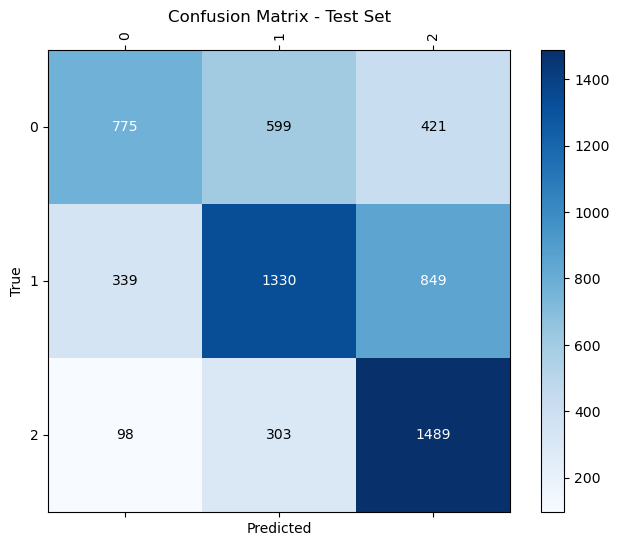

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.43      0.52      1795
           1       0.60      0.53      0.56      2518
           2       0.54      0.79      0.64      1890

    accuracy                           0.58      6203
   macro avg       0.59      0.58      0.57      6203
weighted avg       0.59      0.58      0.57      6203



In [19]:
# Predict on the validation set
# Predict on the test set
y_test_pred = model.predict(X_test)

# Confusion Matrix
class_labels = ['0', '1', '2']

# Calculate the confusion matrix
unique_labels = np.unique(np.concatenate((y_test, y_test_pred)))
cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)

# Set labels to be integers from unique_labels for both axes
ax.set_xticklabels([''] + unique_labels.tolist(), rotation=90)
ax.set_yticklabels([''] + unique_labels.tolist())

# Label axes
plt.xlabel('Predicted')
plt.ylabel('True')

# Title and grid
plt.title('Confusion Matrix - Test Set', pad=20)
plt.grid(False)  # Turn off the grid for confusion matrix

# Use white text if squares are dark; otherwise black
threshold = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > threshold else "black")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

In [116]:
# Save the accuracy for comparison later
accuracy_logistic = 0.58

The reported accuracy of 58% indicates the model's performance when utilizing manual functions to define sentiment based on words rather than employing embedding techniques.  The observed accuracy could be influenced by factors such as model complexity or suboptimal hyperparameters, as the model may not effectively learn and generalize patterns from the input data, leading to lower overall performance.  Further optimization, including fine-tuning hyperparameters and considering alternative model architectures, may be necessary to enhance accuracy and improve sentiment analysis outcomes.

# Model 2: Fasttext-Based Embedding

FastText-based embedding is an advanced technique in sentiment analysis that extends the concept of word embeddings by not only considering whole words but also taking into account subword information, such as suffixes and prefixes. In FASTTEXT, each word is modeled by a sum of vectors, with each vector representing an n-gram (Athiwaratkun, et al., 2018).

In [12]:
df = data.copy()

In [13]:
def tokenizer(text: str) -> list:
  #TODO: your code goes here
  for punctuation in string.punctuation:
      text = text.replace(punctuation, ' ' + punctuation + ' ')
  return text.split()

def word_lemmatize(tokens: list) -> list:
  lemmatizer = WordNetLemmatizer()
  lemmatized_tokens = [lemmatizer.lemmatize(token, wordnet.VERB) for token in tokens]
  return lemmatized_tokens

def remove_stopwords(tokens: list) -> list:
  #TODO: your code goes here
  # Create a set of stop words from spaCy's STOP_WORDS
  stop_words = set(STOP_WORDS)

  # Filter out tokens that are not in the stop words set
  filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
  return filtered_tokens

def join_tokens(tokens: list) -> str:
  return ' '.join(tokens)

def preprocess_text(text):
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-zA-Z\s\']', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(' +', ' ', text)
    # Remove leading and trailing whitespaces
    text = text.strip()
    return text

In [14]:
# Encode sentiment labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

In [17]:
df['tokenized_sentence'] = df['text'].apply(tokenizer)
df['lemmatized_sentence'] = df['tokenized_sentence'].apply(word_lemmatize)
df['final_sentence'] = df['lemmatized_sentence'].apply(join_tokens)
df['final_sentence'] = df['final_sentence'].apply(preprocess_text)
df = df[['text','label', 'final_sentence']]

In [18]:
df.head()

text  label  \
0                I`d have responded, if I were going      1   
1      Sooo SAD I will miss you here in San Diego!!!      0   
2                          my boss is bullying me...      0   
3                     what interview! leave me alone      0   
4   Sons of ****, why couldn`t they put them on t...      0   

                                      final_sentence  
0                        i d have respond if i be go  
1         sooo sad i will miss you here in san diego  
2                                my boss be bully me  
3                      what interview leave me alone  
4  sons of why couldn t they put them on the rele...

In [19]:
df.isnull().sum()

text              0
label             0
final_sentence    0
dtype: int64

In [20]:
sentences = [sentence.split() for sentence in df['text']]
fasttext_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4, sg=1)

In [21]:
def embed_sentences(sentences, model):
    embeddings = []
    for sentence in sentences:
        embedding = []
        for word in sentence:
            if word in model.wv:
                embedding.append(model.wv[word])
        if embedding:
            sentence_embedding = np.mean(embedding, axis=0)
        else:
            sentence_embedding = np.zeros(model.vector_size)
        embeddings.append(sentence_embedding)
    return np.array(embeddings)

In [22]:
df_embeddings = pd.DataFrame(embed_sentences([sentence.split() for sentence in df['final_sentence']], fasttext_model))
df_final = pd.concat([df.reset_index(drop=True), df_embeddings.reset_index(drop=True)], axis=1)
df_final = df_final.drop(columns=['text', 'final_sentence'])
df_final.head()

label         0         1         2         3         4         5  \
0      1  0.021429  0.045380 -0.112108  0.024436  0.064201 -0.157481   
1      0 -0.022141  0.204533 -0.098225  0.045559  0.158156 -0.102443   
2      0  0.046033  0.033449 -0.085012  0.157725  0.033491 -0.045934   
3      0  0.098839 -0.076310 -0.109371  0.076930  0.041043 -0.137785   
4      0 -0.036272  0.162759 -0.136569  0.009726  0.130246 -0.120410   

          6         7         8  ...        90        91        92        93  \
0  0.014546  0.430883 -0.125970  ... -0.000330  0.017455  0.248905  0.026325   
1  0.030770  0.453826 -0.195055  ...  0.085453 -0.134277  0.169641  0.037794   
2  0.121827  0.446301 -0.031617  ... -0.045359 -0.188249  0.181175 -0.052144   
3  0.029708  0.362089 -0.091169  ...  0.093458 -0.097476  0.342244 -0.132864   
4  0.006516  0.435893  0.003685  ...  0.122710  0.043296  0.139266 -0.005977   

         94        95        96        97        98        99  
0 -0.013897 -0.107666 -0.020041 -0.185121 -0.010639 -0.099321  
1 -0.021529 -0.011606  0.002137 -0.238665 -0.098748 -0.183476  
2  0.048937 -0.114938  0.066009 -0.263243  0.056767 -0.106183  
3 -0.034210 -0.180291  0.113684 -0.308818 -0.030433 -0.067472  
4 -0.008682 -0.213294  0.066748 -0.215337 -0.012349 -0.139330  

[5 rows x 101 columns]

After preprocessing the data, it is partitioned into training, validation, and test sets to ensure a proper evaluation framework. Standardization is applied to the data to prevent overfitting by normalizing the feature scales. Within the model, early stopping and learning rate reduction techniques are implemented as safeguards against overfitting. Subsequently, the model undergoes fine-tuning to enhance its performance, which includes increasing its complexity to capture more nuanced patterns in the data effectively.

In [23]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(df_final.drop(columns=['label']), df_final['label'], test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_val_standardized = scaler.transform(X_val)
X_test_standardized = scaler.transform(X_test)

In [25]:
# Define the MLP model with dropout and L2 regularization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_standardized.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  
])

# Compile the model with binary cross-entropy loss
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model with callbacks for early stopping and learning rate reduction
history = model.fit(
    X_train_standardized, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_standardized, y_val)
)

Epoch 1/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.3774 - loss: -11.8861 - val_accuracy: 0.4090 - val_loss: -1830.5485
Epoch 2/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4058 - loss: -24185.7910 - val_accuracy: 0.4090 - val_loss: -315059.1250
Epoch 3/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4094 - loss: -747922.8750 - val_accuracy: 0.4090 - val_loss: -3115304.0000
Epoch 4/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4187 - loss: -4665049.5000 - val_accuracy: 0.4090 - val_loss: -12283095.0000
Epoch 5/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4136 - loss: -15554575.0000 - val_accuracy: 0.4090 - val_loss: -33640620.0000
Epoch 6/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4089 - loss: -36161296.0000 - val_accuracy: 0.4090 - val_loss: -74197496.0000
Epoch 7/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4054 - loss: -84320496.0000 - val_accuracy: 0.4090 - val_loss: -140386768.0000
Epo

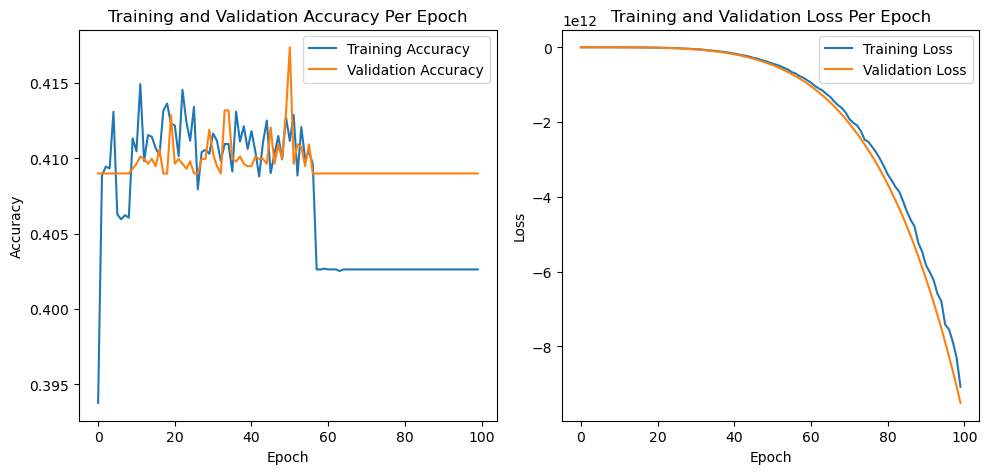

In [26]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plotting the training and validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy Per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plotting the training and validation loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss Per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

Several improvements have been made to the model. First, it includes L2 regularization, which helps prevent overfitting by penalizing large parameter values. This regularization technique encourages the model to learn simpler patterns, making it more robust to variations in the data. Moreover, using the softmax activation function, the model now outputs three probabilities corresponding to each class, enabling it to perform multi-class classification. Finally, early stopping and learning rate reduction callbacks during training enhance model performance by preventing overfitting and optimizing the learning process.

In [37]:
# Define the MLP model with dropout and L2 regularization
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_standardized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  
])

# Compile the model with the Adam optimizer and a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Train the model with callbacks for early stopping and learning rate reduction
history = model.fit(
    X_train_standardized, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_standardized, y_val), 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


C:\Users\ynels\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.3696 - loss: 1.4200 - val_accuracy: 0.4090 - val_loss: 1.2666 - learning_rate: 5.0000e-04
Epoch 2/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4001 - loss: 1.2651 - val_accuracy: 0.4551 - val_loss: 1.2248 - learning_rate: 5.0000e-04
Epoch 3/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4220 - loss: 1.2250 - val_accuracy: 0.5009 - val_loss: 1.1606 - learning_rate: 5.0000e-04
Epoch 4/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4514 - loss: 1.1765 - val_accuracy: 0.5223 - val_loss: 1.0976 - learning_rate: 5.0000e-04
Epoch 5/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4684 - loss: 1.1310 - val_accuracy: 0.5312 - val_loss: 1.0543 - learning_rate: 5.0000e-04
Epoch 6/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4765 - loss: 1.0954 - val_accuracy: 0.5389 - val_loss: 1.0268 - learning_rate: 5.0000e-04
Epoch 7/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.496

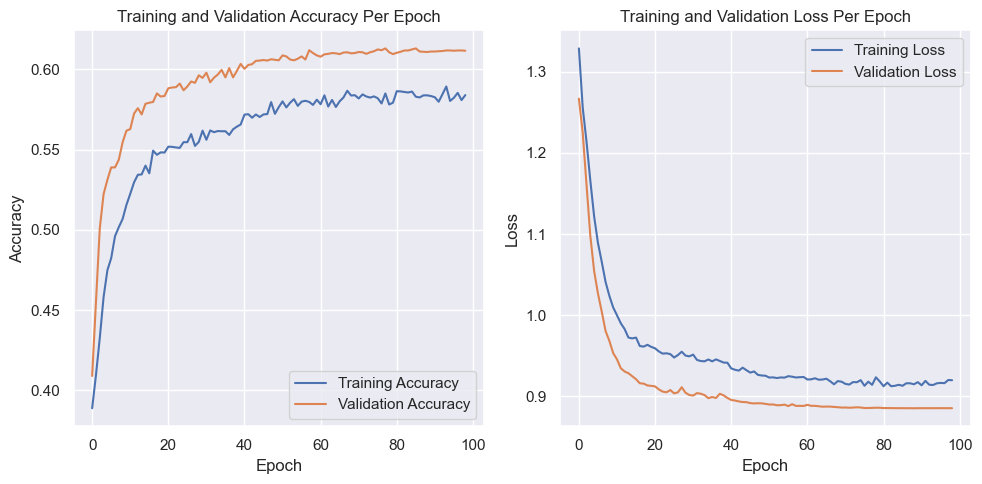

In [38]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plotting the training and validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy Per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plotting the training and validation loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss Per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In the initial assessment of our machine learning model, the training and validation accuracies displayed a promising convergence, suggesting that there is no overfitting. However, both training and validation accuracies hinted at the potential for performance enhancement.

In [39]:
# Define the MLP model with dropout and L2 regularization
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_standardized.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')  
])

# Compile the model with the Adam optimizer and a smaller learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)

# Train the model with callbacks for early stopping and learning rate reduction
history = model.fit(
    X_train_standardized, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val_standardized, y_val), 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3682 - loss: 2.0147 - val_accuracy: 0.4090 - val_loss: 1.7992 - learning_rate: 5.0000e-04
Epoch 2/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4026 - loss: 1.7477 - val_accuracy: 0.4838 - val_loss: 1.5519 - learning_rate: 5.0000e-04
Epoch 3/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4613 - loss: 1.5197 - val_accuracy: 0.4973 - val_loss: 1.3585 - learning_rate: 5.0000e-04
Epoch 4/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4825 - loss: 1.3374 - val_accuracy: 0.5044 - val_loss: 1.2187 - learning_rate: 5.0000e-04
Epoch 5/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4857 - loss: 1.2166 - val_accuracy: 0.5157 - val_loss: 1.1182 - learning_rate: 5.0000e-04
Epoch 6/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4926 - loss: 1.1245 - val_accuracy: 0.5088 - val_loss: 1.0653 - learning_rate: 5.0000e-04
Epoch 7/100
582/582 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc

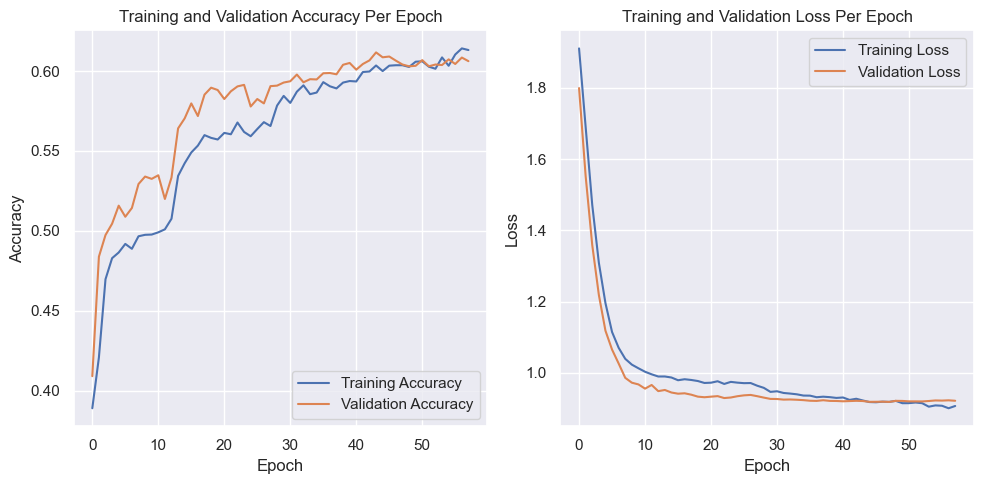

In [40]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plotting the training and validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy Per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plotting the training and validation loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss Per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [150]:
Y_pred = model.predict(X_test_standardized)
Y_pred_classes = np.argmax(Y_pred, axis=1)

194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


C:\Users\ynels\AppData\Local\Temp\ipykernel_17200\150147770.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\ynels\AppData\Local\Temp\ipykernel_17200\150147770.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.49      0.57      1795
           1       0.56      0.75      0.64      2518
           2       0.76      0.60      0.67      1890

    accuracy                           0.63      6203
   macro avg       0.66      0.61      0.63      6203
weighted avg       0.65      0.63      0.63      6203



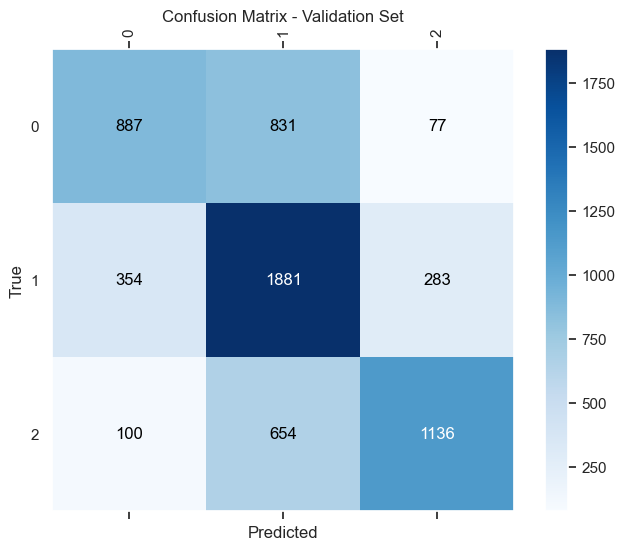

In [153]:
# Calculate the confusion matrix
unique_labels = np.unique(np.concatenate((y_test, Y_pred_classes)))
cm = confusion_matrix(y_test, Y_pred_classes, labels=unique_labels)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)

# Set labels to be integers from unique_labels for both axes
ax.set_xticklabels([''] + unique_labels.tolist(), rotation=90)
ax.set_yticklabels([''] + unique_labels.tolist())

# Label axes
plt.xlabel('Predicted')
plt.ylabel('True')

# Title and grid
plt.title('Confusion Matrix - Validation Set', pad=20)
plt.grid(False)  # Turn off the grid for confusion matrix

# Use white text if squares are dark; otherwise black
threshold = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > threshold else "black")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, Y_pred_classes))

In [154]:
accuracy_fasttext = 0.63

This is a moderate performance and suggests that the model has a decent capability to distinguish between classes compared to the traditional logistic method. It performs better in identifying class 2 instances with high precision but is less effective in recognizing instances of class 0. The balance between precision and recall, as reflected in the F1-scores, suggests that the model's performance is consistent, yet there is room for improvement, especially in correctly identifying all instances of each class without making many incorrect predictions.

# Model 3: Sequential LSTM Model

The Sequential LSTM (Long Short-Term Memory) model is a recurrent neural network architecture used for sequence data processing tasks, such as sentiment analysis. In this method, the input text data is first tokenized using a Tokenizer, which converts words into numerical representations. These tokenized sequences are then transformed into fixed-length sequences through padding to ensure uniform input dimensions. This final model involves a combination of Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) layers. This hybrid architecture allows for the exploitation of both local and global contextual information in the input text data.By combining the regional CNN and LSTM, both local (regional) information within sentences and long-distance dependency across sentences can be considered in the prediction process (Wang. J, et al., 2016).

In [158]:
df = data.copy()
df

textID                                               text sentiment
0      cb774db0d1                I`d have responded, if I were going   neutral
1      549e992a42      Sooo SAD I will miss you here in San Diego!!!  negative
2      088c60f138                          my boss is bullying me...  negative
3      9642c003ef                     what interview! leave me alone  negative
4      358bd9e861   Sons of ****, why couldn`t they put them on t...  negative
...           ...                                                ...       ...
31010  e5f0e6ef4b  its at 3 am, im very tired but i can`t sleep  ...  negative
31011  416863ce47  All alone in this old house again.  Thanks for...  positive
31012  6332da480c   I know what you mean. My little dog is sinkin...  negative
31013  df1baec676  _sutra what is your next youtube video gonna b...  positive
31014  469e15c5a8   http://twitpic.com/4woj2 - omgssh  ang cute n...  positive

[31014 rows x 3 columns]

In [159]:
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove stopwords
    stopwords_list = set(stopwords.words('english'))
    text = " ".join(word for word in text.split() if word not in stopwords_list)
    
    # Remove punctuations
    punctuations_list = string.punctuation
    translator = str.maketrans('', '', punctuations_list)
    text = text.translate(translator)
    
    # Remove repeating characters
    text = re.sub(r'(.)\1+', r'\1', text)
    
    # Remove email addresses
    text = re.sub('@[^\s]+', ' ', text)
    
    # Remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    
    # Remove numbers
    text = re.sub('[0-9]+', '', text)
    
    return text

In [160]:
# Encode sentiment labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment'])

In [161]:
df['sentence'] = df['text'].apply(preprocess_text)
df = df[['sentence', 'label']]
df.head()

sentence  label
0                        id responded going      1
1                      so sad mis san diego      0
2                            bos bulying me      0
3                     interview leave alone      0
4  sons couldnt put releases already bought      0

In [13]:
def tokenize_stem_lemmatize(text):
    # Tokenize text
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)
    
    # Stemming
    st = PorterStemmer()
    stemmed_tokens = [st.stem(word) for word in tokens]
    
    # Lemmatization
    lm = WordNetLemmatizer()
    lemmatized_tokens = [lm.lemmatize(word) for word in stemmed_tokens]
    
    return lemmatized_tokens

In [162]:
# Apply tokenize_stem_lemmatize function to 'text' column
df['text'] = df['sentence'].apply(tokenize_stem_lemmatize)
df.head()

sentence  label  \
0                        id responded going      1   
1                      so sad mis san diego      0   
2                            bos bulying me      0   
3                     interview leave alone      0   
4  sons couldnt put releases already bought      0   

                                           text  
0                             [id, respond, go]  
1                     [so, sad, mi, san, diego]  
2                                [bo, buli, me]  
3                       [interview, leav, alon]  
4  [son, couldnt, put, releas, alreadi, bought]

In [163]:
X=df.text
y=df.label

In [164]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [165]:
sequences_matrix.shape

(31014, 500)

After preprocessing the sequences, a deep-learning model was constructed to perform sentiment analysis. The model architecture consisted of an input layer and embedding layers for word representation, followed by LSTM layers for sequence processing. Initially, the model was configured with a single output neuron and sigmoid activation for binary classification. However, to accommodate the three output classes in the dataset, the model was later fine-tuned to include three output neurons with softmax activation, enabling multi-class classification. This adjustment allowed the model to generate probabilities for each sentiment category, enhancing its predictive capabilities.

In [166]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [178]:
def tensorflow_based_model(max_len=500): 
    inputs = Input(name='inputs', shape=[max_len])  # Define input layer with input_length
    layer = Embedding(2000, 50)(inputs)  # Remove input_length argument from Embedding layer
    layer = LSTM(64)(layer) 
    layer = Dense(256, name='FC1')(layer) 
    layer = Activation('relu')(layer) 
    layer = Dropout(0.5)(layer) 
    layer = Dense(1, name='out_layer')(layer) 
    layer = Activation('sigmoid')(layer) 
    model = Model(inputs=inputs, outputs=layer) 
    return model 

In [181]:
model = tensorflow_based_model() 
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [182]:
history=model.fit(X_train,Y_train,batch_size=150,epochs=8, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 61s 437ms/step - accuracy: 0.4060 - loss: -0.1067 - val_accuracy: 0.4007 - val_loss: -1.4572
Epoch 2/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 422ms/step - accuracy: 0.4204 - loss: -5.7389 - val_accuracy: 0.4965 - val_loss: -41.7927
Epoch 3/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 423ms/step - accuracy: 0.4641 - loss: -44.5154 - val_accuracy: 0.4841 - val_loss: -108.1957
Epoch 4/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 428ms/step - accuracy: 0.4934 - loss: -133.8484 - val_accuracy: 0.4247 - val_loss: -241.7130
Epoch 5/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 427ms/step - accuracy: 0.4784 - loss: -299.0132 - val_accuracy: 0.4929 - val_loss: -439.3959
Epoch 6/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 424ms/step - accuracy: 0.4925 - loss: -520.8376 - val_accuracy: 0.4970 - val_loss: -690.4914
Epoch 7/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 55s 421ms/step - accuracy: 0.5016 - loss: -804.4510 - val_accuracy: 0.5076 - val_loss: -995.0031
Epoch 8/8
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 424ms/step - 

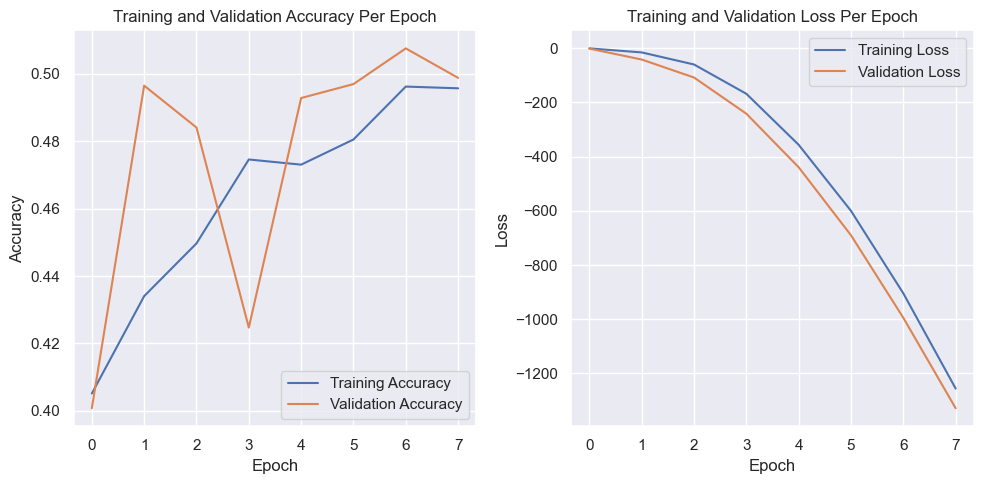

In [183]:
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plotting the training and validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy Per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plotting the training and validation loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss Per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

The updated model introduces several enhancements to its architecture and training process: <br>

1. It incorporates a multi-class classification approach using the softmax activation function in the output layer, enabling it to predict probabilities across three classes instead of binary classification. This modification allows the model to discern sentiment nuances more accurately.<br>

2. The addition of the early stopping callback prevents overfitting by monitoring the validation loss and terminating training when no further improvements are observed over a specified number of epochs, thereby enhancing generalization performance.

In [171]:
def tensorflow_based_model(max_len=500, vocab_size=2000): 
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(vocab_size, 50)(inputs)
    layer = LSTM(64)(layer) 
    layer = Dense(256, name='FC1')(layer) 
    layer = Activation('relu')(layer) 
    layer = Dropout(0.5)(layer) 
    layer = Dense(3, name='out_layer')(layer)  # 3 output units for multi-class classification
    layer = Activation('softmax')(layer)  # Use softmax activation for multi-class classification
    model = Model(inputs=inputs, outputs=layer) 
    
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    return model, early_stopping

# Create model and early stopping object
model, early_stopping = tensorflow_based_model()

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

In [172]:
history2=model.fit(X_train,Y_train,batch_size=100,epochs=20, validation_split=0.1, callbacks=[early_stopping])# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 68s 330ms/step - accuracy: 0.4519 - loss: 1.0414 - val_accuracy: 0.6702 - val_loss: 0.7651
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 64s 326ms/step - accuracy: 0.6768 - loss: 0.7625 - val_accuracy: 0.7089 - val_loss: 0.6953
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 63s 321ms/step - accuracy: 0.7179 - loss: 0.6925 - val_accuracy: 0.7227 - val_loss: 0.6890
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 60s 306ms/step - accuracy: 0.7335 - loss: 0.6619 - val_accuracy: 0.7236 - val_loss: 0.6817
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 61s 312ms/step - accuracy: 0.7460 - loss: 0.6409 - val_accuracy: 0.7172 - val_loss: 0.6909
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 61s 311ms/step - accuracy: 0.7509 - loss: 0.6275 - val_accuracy: 0.7241 - val_loss: 0.6816
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 61s 311ms/step - accuracy: 0.7599 - loss: 0.6155 - val_accuracy: 0.7236 - val_loss: 0.6798
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 61s 311ms/step - accuracy: 0.7604 - loss: 0

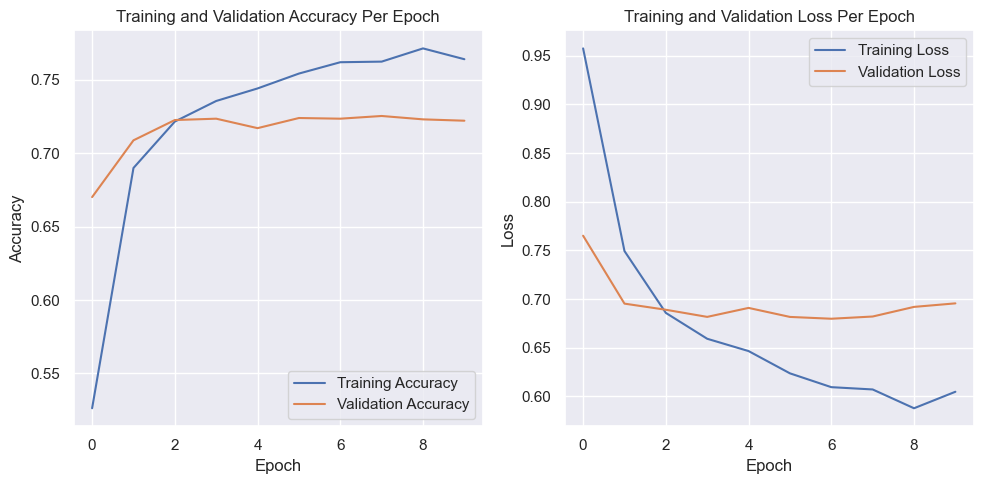

In [173]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plotting the training and validation accuracy
axes[0].plot(history2.history['accuracy'], label='Training Accuracy')
axes[0].plot(history2.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training and Validation Accuracy Per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plotting the training and validation loss
axes[1].plot(history2.history['loss'], label='Training Loss')
axes[1].plot(history2.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training and Validation Loss Per Epoch')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()

In [174]:
# Predict the class labels for the test data
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)

291/291 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step


C:\Users\ynels\AppData\Local\Temp\ipykernel_17200\406440930.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\ynels\AppData\Local\Temp\ipykernel_17200\406440930.py:11: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67      2651
           1       0.66      0.75      0.70      3747
           2       0.76      0.76      0.76      2907

    accuracy                           0.71      9305
   macro avg       0.72      0.71      0.71      9305
weighted avg       0.72      0.71      0.71      9305



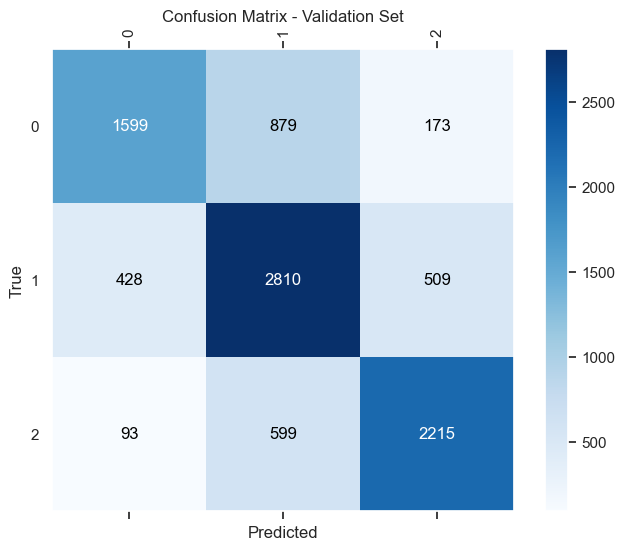

In [175]:
# Calculate the confusion matrix
unique_labels = np.unique(np.concatenate((Y_test, Y_pred_classes)))
cm = confusion_matrix(Y_test, Y_pred_classes, labels=unique_labels)

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)

# Set labels to be integers from unique_labels for both axes
ax.set_xticklabels([''] + unique_labels.tolist(), rotation=90)
ax.set_yticklabels([''] + unique_labels.tolist())

# Label axes
plt.xlabel('Predicted')
plt.ylabel('True')

# Title and grid
plt.title('Confusion Matrix - Validation Set', pad=20)
plt.grid(False)  # Turn off the grid for confusion matrix

# Use white text if squares are dark; otherwise black
threshold = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > threshold else "black")

# Print the classification report
print("Classification Report:")
print(classification_report(Y_test, Y_pred_classes))

In [176]:
accuracy_SequentialLSTM = 0.71

With an overall accuracy of 71%, the model demonstrates proficiency in predicting sentiment categories. The F1-score, a harmonic mean of precision and recall, ranges from 0.67 to 0.76, reflecting the model's balance between precision and recall. The support values indicate the number of instances in each sentiment category, with a higher number of instances for class 1 compared to classes 0 and 2. Overall, the model achieves a balanced performance across the sentiment categories, as evidenced by the weighted average scores and accuracy score.

# Conclusion

In [177]:
# Comparison
result_table = pd.DataFrame({
    'Model': ['Logistic Regression', 'Fasttext Embedding', 'Sequential LSTM'],
    'Accuracy': [accuracy_logistic, accuracy_fasttext, accuracy_SequentialLSTM]
})

result_table

Model  Accuracy
0  Logistic Regression      0.58
1   Fasttext Embedding      0.63
2      Sequential LSTM      0.71

The comparison of the three models reveals varying levels of performance in sentiment analysis. The logistic regression model achieved an accuracy of 58%, indicating its ability to classify sentiment to a limited extent. The fasttext embedding model demonstrated a slight improvement with an accuracy of 63%, suggesting that the inclusion of word embeddings enhanced sentiment classification. However, the sequential LSTM model outperformed both previous models significantly, achieving an accuracy of 71%. 

The sequential LSTM model performs superiorly due to its ability to capture sequential dependencies in text data, which helps extract more nuanced features and patterns related to sentiment. Additionally, the LSTM model's architecture effectively handles the complexities of text data, leading to better performance than simpler models like logistic regression and fasttext embedding. As a result, the sequential LSTM model is the top performer in sentiment analysis because it can leverage sequential information and capture subtle nuances in the text, thus improving classification accuracy.

The logistic regression model's disadvantage lies in its simplicity and inability to capture complex relationships in text data. It relies solely on linear decision boundaries and may struggle to model the intricate nuances of language. Similarly, while the fasttext embedding model benefits from word embeddings to capture semantic information, it still lacks the ability to model sequential dependencies effectively

To further improve sentiment analysis in the future, several strategies can be employed. Firstly, incorporating pre-trained language models (LLMs) like BERT or GPT could enhance the model's understanding of context and semantics. Furthermore, fine-tuning hyperparameters and conducting more extensive grid search could optimize model performance. 

# References

Athiwaratkun, B., Wilson, A. G., & Anandkumar, A. (2018). Probabilistic fasttext for multi-sense word embeddings. arXiv preprint arXiv:1806.02901.

Hidayat, T. H. J., Ruldeviyani, Y., Aditama, A. R., Madya, G. R., Nugraha, A. W., & Adisaputra, M. W. (2022). Sentiment analysis of twitter data related to Rinca Island development using Doc2Vec and SVM and logistic regression as classifier. Procedia Computer Science, 197, 660-667.

Tyagi, A., & Sharma, N. (2018). Sentiment analysis using logistic regression and effective word score heuristic. International Journal of Engineering and Technology (UAE), 7(2.24), 20-23.

Wang, J., Yu, L. C., Lai, K. R., & Zhang, X. (2016, August). Dimensional sentiment analysis using a regional CNN-LSTM model. In Proceedings of the 54th annual meeting of the association for computational linguistics (volume 2: Short papers) (pp. 225-230).